In [12]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from Numpy.make_Ab import make_Ab

from Numpy.cg import cg as cg_cpu
from Numpy.gcr import gcr as gcr_cpu
from Numpy.gmres import gmres as gmres_cpu

from Numpy.vpgcr import vpgcr as vpgcr_cpu

from Numpy.vrm import vrm as vrm_cpu
from Numpy.ivrm import ivrm as ivrm_cpu



import cupy as cp
from CuPy.SingleGpu.cg import cg as cg_sgpu
from CuPy.SingleGpu.gcr import gcr as gcr_sgpu

from CuPy.SingleGpu.vpgcr import vpgcr as vpgcr_sgpu

from CuPy.SingleGpu.ivrm import ivrm as ivrm_sgpu

In [13]:
n = 6881
matrix_path = f"../../../Matrixes/EFG/matrix_EFG-{n}.txt"
vector_path = f"../../../Matrixes/EFG/vector_EFG-{n}.txt"
A, b, c = make_Ab(matrix_path, path_vector=vector_path, n=n)
ndata = int(c[0])
nbound = int(c[1])

In [14]:
maxiter = n*2

### CPU

13761
38.736565926112235
456
3.32440380519256
712
27.338422794127837


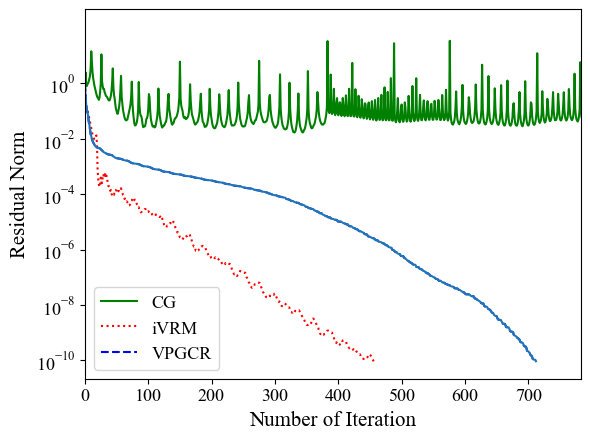

In [23]:
# CG
plt.rcParams['font.family'] = 'Times New Roman'
x, info = cg_cpu(A, b, n, maxiter, tol=1.0e-10)
plt.plot(info['residual'], color='g', label="CG", linestyle="-")
print(info['iterations'])
print(info['time'])

# iVRM-CG
x, info = ivrm_cpu(A, b, n, maxiter, ndata, nbound, cg_cpu)
print(info['iterations'])
plt.plot(info['residual'], color='r', label='iVRM', linestyle=":")
print(info['time'])

# VPGCR-GCR
x, info = vpgcr_cpu(A, b, n, maxiter, gcr_cpu, 10, inner_tol=10**(-1))
print(info['iterations'])
plt.plot(info['residual'], color='b', label='VPGCR', linestyle="--")
print(info['time'])



plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 14
plt.rcParams['xtick.labelsize'] = 14 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 14 # 軸だけ変更されます
plt.xlabel('Number of Iteration')
plt.ylabel('Residual Norm')
plt.xlim(0, info['iterations']+ info['iterations']//10)
plt.yscale('log')
plt.yticks([10**i for i in range(0, -12, -2)]) 
plt.legend(fontsize=13)
plt.plot(info['residual'])
plt.savefig('residual.pdf')

In [56]:
number_of_attemps = 10
time = np.zeros(3, dtype = np.float32)
for i in range(number_of_attemps):
	# CG
	x, info = cg_cpu(A, b, n, maxiter, tol=1.0e-10)
	time[0] += info['time']

	# iVRM-CG
	x, info = ivrm_cpu(A, b, n, maxiter, ndata, nbound, cg_cpu)
	time[1] += info['time']

	# VPGCR-GCR
	x, info = vpgcr_cpu(A, b, n, maxiter, gcr_cpu, 10, inner_tol=10**(-1))
	time[2] += info['time']

time = time/number_of_attemps
np.savetxt(f'out_cpu_{n}.csv', time, delimiter=',')

### GPU

13761
7.309280742076226
456
1.152614495018497
715
7.153694657958113


([<matplotlib.axis.YTick at 0x14d28d073d40>,
 [Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 1e-08, '$\\mathdefault{10^{-8}}$'),
  Text(0, 1e-10, '$\\mathdefault{10^{-10}}$')])

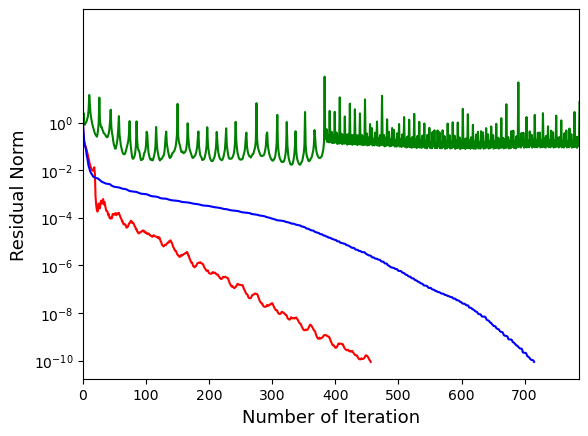

In [32]:
# CG
x, info = cg_sgpu(A, b, n, maxiter, tol=1.0e-10)
plt.plot(cp.asnumpy(info['residual']), color='g')
print(info['iterations'])
print(info['time'])

# iVRM
x, info = ivrm_sgpu(A, b, n, maxiter, ndata, nbound, cg_sgpu)
plt.plot(cp.asnumpy(info['residual']), color='r')
print(info['iterations'])
print(info['time'])

# vpgcr-gcr
x, info = vpgcr_sgpu(A, b, n, maxiter, gcr_sgpu, 10, inner_tol=10**(-1))
plt.plot(cp.asnumpy(info['residual']), color='b')
print(info['iterations'])
print(info['time'])

plt.xlabel('Number of Iteration', fontsize=13)
plt.ylabel('Residual Norm', fontsize=13)
plt.xlim(0, info['iterations']+ info['iterations']//10)
plt.yscale('log')
plt.yticks([10**i for i in range(0, -12, -2)]) 

In [57]:
number_of_attemps = 10
time = np.zeros(3, dtype = np.float32)
for i in range(number_of_attemps):
	# CG
	x, info = cg_sgpu(A, b, n, maxiter, tol=1.0e-10)
	time[0] += cp.asnumpy(info['time'])

	# iVRM-CG
	x, info = ivrm_sgpu(A, b, n, maxiter, ndata, nbound, cg_sgpu)
	time[1] += cp.asnumpy(info['time'])

	# VPGCR-GCR
	x, info = vpgcr_sgpu(A, b, n, maxiter, gcr_sgpu, 10, inner_tol=10**(-1))
	time[2] += cp.asnumpy(info['time'])


time = time/number_of_attemps
np.savetxt(f'out_sgpu_{n}.csv', time, delimiter=',')

<BarContainer object of 4 artists>

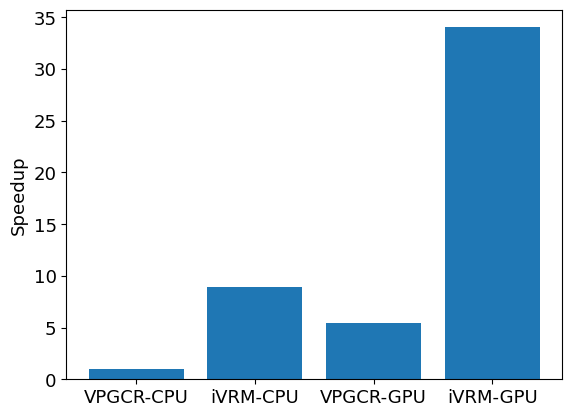

In [88]:
cpu_sec = np.loadtxt('out_cpu_6881.csv')
sgpu_sec = np.loadtxt('out_sgpu_6881.csv')

mname = ['VPGCR-CPU', 'iVRM-CPU', 'VPGCR-GPU', 'iVRM-GPU']
speedup = np.zeros(len(mname))
speedup[0] = cpu_sec[2] / cpu_sec[2]
speedup[1] = cpu_sec[2] / cpu_sec[1]
speedup[2] = cpu_sec[2] / sgpu_sec[2]
speedup[3] = cpu_sec[2] / sgpu_sec[1]
plt.ylabel('Speedup', fontsize=13)
plt.bar(mname, speedup, align="center")

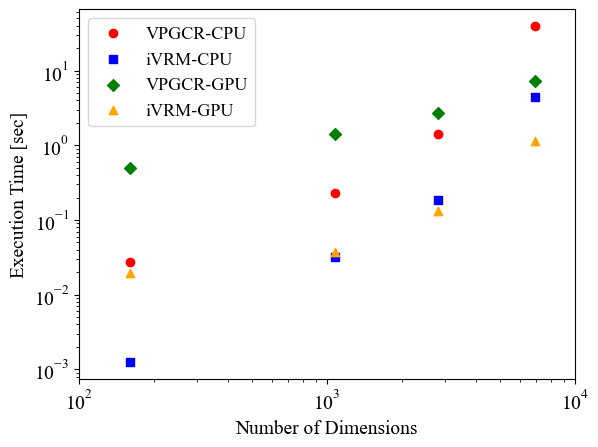

In [24]:
n_matrixes = [161, 1081, 2801, 6881]
n_dimentions = len(n_matrixes)
ivrm_cput = np.zeros(n_dimentions)
ivrm_gput = np.zeros(n_dimentions)
vpgcr_cput = np.zeros(n_dimentions)
vpgcr_gput = np.zeros(n_dimentions)

counter = 0
for i in n_matrixes:
	cpu_sec = np.loadtxt(f'out_cpu_{i}.csv')
	sgpu_sec = np.loadtxt(f'out_sgpu_{i}.csv')

	ivrm_cput[counter] = cpu_sec[1]
	ivrm_gput[counter] = sgpu_sec[1]
	vpgcr_cput[counter] = cpu_sec[2]
	vpgcr_gput[counter] = sgpu_sec[2]

	counter += 1
import matplotlib

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 14
plt.rcParams['xtick.labelsize'] = 14 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 14 # 軸だけ変更されます

plt.scatter(n_matrixes, vpgcr_cput, marker="o", color='r', label="VPGCR-CPU")
plt.scatter(n_matrixes, ivrm_cput, marker="s", color='b', label="iVRM-CPU")
plt.scatter(n_matrixes, vpgcr_gput, marker="D", color='g', label="VPGCR-GPU")
plt.scatter(n_matrixes, ivrm_gput, marker="^", color='orange', label="iVRM-GPU")

plt.xlabel(r'Number of Dimensions')
plt.ylabel('Execution Time [sec]')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10**2, 10**4)
plt.legend(fontsize=13)
plt.savefig('ctime.pdf')

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})



[1.25164178e-03 3.18342336e-02 1.87841430e-01 4.40642691e+00]
[15.55604123  1.15535741  0.70852372  0.26250475]


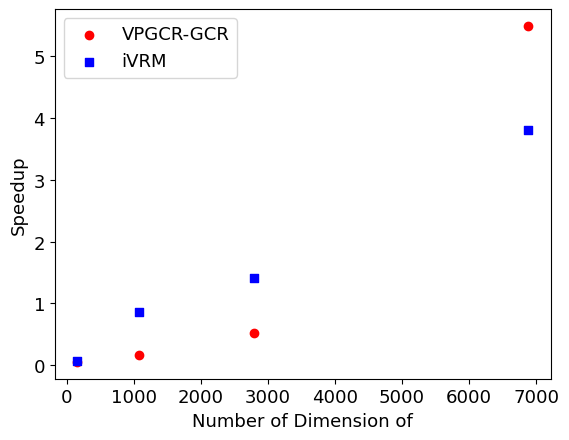

In [94]:
n_matrixes = [161, 1081, 2801, 6881]
n_dimentions = len(n_matrixes)
ivrm_cput = np.zeros(n_dimentions)
ivrm_gput = np.zeros(n_dimentions)
vpgcr_cput = np.zeros(n_dimentions)
vpgcr_gput = np.zeros(n_dimentions)

counter = 0
for i in n_matrixes:
	cpu_sec = np.loadtxt(f'out_cpu_{i}.csv')
	sgpu_sec = np.loadtxt(f'out_sgpu_{i}.csv')

	ivrm_cput[counter] = cpu_sec[1]
	ivrm_gput[counter] = sgpu_sec[1]
	vpgcr_cput[counter] = cpu_sec[2]
	vpgcr_gput[counter] = sgpu_sec[2]

	counter += 1

print(ivrm_cput)
print(ivrm_gput/ivrm_cput)


plt.scatter(n_matrixes, vpgcr_cput/vpgcr_gput, marker="o", color='r', label="VPGCR-GCR")
plt.scatter(n_matrixes, ivrm_cput/ivrm_gput, marker="s", color='b', label="iVRM")

plt.xlabel('Number of Dimensions', fontsize=13)
plt.ylabel('Speedup', fontsize=13)
# plt.yscale('log')
# plt.xscale('log')
plt.legend(fontsize=13)

[1.25164178e-03 3.18342336e-02 1.87841430e-01 4.40642691e+00]
[15.55604123  1.15535741  0.70852372  0.26250475]


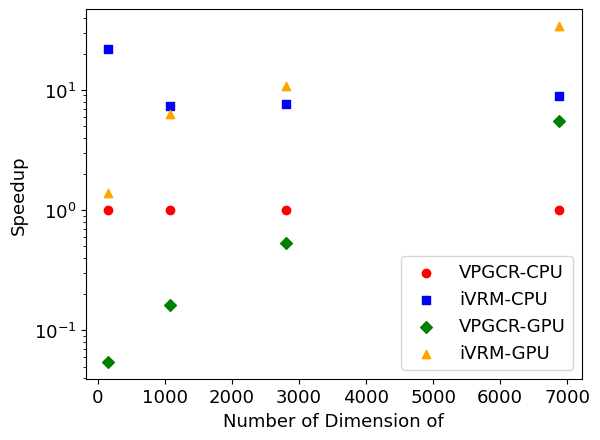

In [99]:
n_matrixes = [161, 1081, 2801, 6881]
n_dimentions = len(n_matrixes)
ivrm_cput = np.zeros(n_dimentions)
ivrm_gput = np.zeros(n_dimentions)
vpgcr_cput = np.zeros(n_dimentions)
vpgcr_gput = np.zeros(n_dimentions)

counter = 0
for i in n_matrixes:
	cpu_sec = np.loadtxt(f'out_cpu_{i}.csv')
	sgpu_sec = np.loadtxt(f'out_sgpu_{i}.csv')

	ivrm_cput[counter] = cpu_sec[1]
	ivrm_gput[counter] = sgpu_sec[1]
	vpgcr_cput[counter] = cpu_sec[2]
	vpgcr_gput[counter] = sgpu_sec[2]

	counter += 1

print(ivrm_cput)
print(ivrm_gput/ivrm_cput)


plt.scatter(n_matrixes, vpgcr_cput/vpgcr_cput, marker="o", color='r', label="VPGCR-CPU")
plt.scatter(n_matrixes, vpgcr_cput/ivrm_cput, marker="s", color='b', label="iVRM-CPU")
plt.scatter(n_matrixes, vpgcr_cput/vpgcr_gput, marker="D", color='g', label="VPGCR-GPU")
plt.scatter(n_matrixes, vpgcr_cput/ivrm_gput, marker="^", color='orange', label="iVRM-GPU")

plt.xlabel('Number of Dimensions', fontsize=13)
plt.ylabel('Speedup', fontsize=13)
plt.yscale('log')
# plt.xscale('log')
plt.legend(fontsize=13)

In [ ]:
speedup[0] = cpu_sec[2] / cpu_sec[2]
speedup[1] = cpu_sec[2] / cpu_sec[1]
speedup[2] = cpu_sec[2] / sgpu_sec[2]
speedup[3] = cpu_sec[2] / sgpu_sec[1]

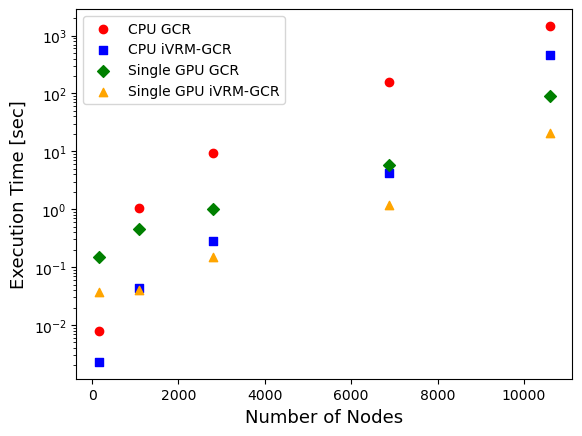

In [3]:
n_matrixes = [161, 1081, 2801, 6881, 10601]
cpu_gcr = [0.0080,  1.0487, 9.2974, 157.6624, 1468.9726]
cpu_ivrm_gcr = [0.0023, 0.0439, 0.2801, 4.2546, 463.5450]
sgpu_gcr = [0.1470, 0.4588, 1.0187, 5.7525, 91.1248]
sgpu_ivrm_gcr = [0.0376, 0.0408, 0.1514, 1.1967, 20.8177]

plt.scatter(n_matrixes, cpu_gcr, marker="o", color='r', label="CPU GCR")
plt.scatter(n_matrixes, cpu_ivrm_gcr, marker="s", color='b', label="CPU iVRM-GCR")
plt.scatter(n_matrixes, sgpu_gcr, marker="D", color='g', label="Single GPU GCR")
plt.scatter(n_matrixes, sgpu_ivrm_gcr, marker="^", color='orange', label="Single GPU iVRM-GCR")

plt.xlabel('Number of Nodes', fontsize=13)
plt.ylabel('Execution Time [sec]', fontsize=13)
plt.yscale('log')
plt.legend(fontsize=10)


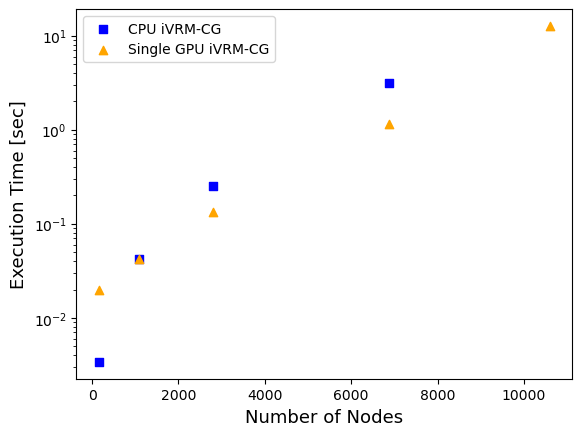

In [4]:
n_matrixes = [161, 1081, 2801, 6881]

cpu_ivrm_cg = [0.0034, 0.04195, 0.2550, 3.1680]
sgpu_ivrm_cg = [0.01967, 0.04183, 0.1342, 1.1542, 12.6960]

plt.scatter(n_matrixes[:-1], cpu_ivrm_cg, marker="s", color='b', label="CPU iVRM-CG")
plt.scatter(n_matrixes, sgpu_ivrm_cg, marker="^", color='orange', label="Single GPU iVRM-CG")

plt.xlabel('Number of Nodes', fontsize=13)
plt.ylabel('Execution Time [sec]', fontsize=13)
plt.yscale('log')
plt.legend(fontsize=10)

In [ ]:
speedup[0] = cpu_sec[2] / cpu_sec[2]
speedup[1] = cpu_sec[2] / cpu_sec[1]
speedup[2] = cpu_sec[2] / sgpu_sec[2]
speedup[3] = cpu_sec[2] / sgpu_sec[1]